In [1]:
import os
import cv2
import numpy as np
from tqdm import tqdm

from albumentations import (
    HorizontalFlip, Rotate, ShiftScaleRotate, RandomBrightnessContrast,
    Compose
)

# === Augmentasi Transformasi
transform = Compose([
    HorizontalFlip(p=0.5),
    Rotate(limit=30, p=0.5),
    ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.5),
    RandomBrightnessContrast(p=0.3)
])

# === Folder Asal dan Simpanan Augmentasi
base_path = r"D:\KULIAH\TELKOM_UNIVERSITY\SEMESTER_8\CITRA_DIGITAL\TUBES\KODE_Train\DATA_SPLIT_BARU\train"
aug_path = os.path.join(base_path + "_aug")

os.makedirs(aug_path, exist_ok=True)

# === Loop semua gambar dan augment
for cls in os.listdir(base_path):
    os.makedirs(os.path.join(aug_path, cls), exist_ok=True)
    for img_name in tqdm(os.listdir(os.path.join(base_path, cls)), desc=cls):
        img_path = os.path.join(base_path, cls, img_name)
        img = cv2.imread(img_path)

        if img is None:
            continue

        # Simpan gambar asli dulu (optional)
        cv2.imwrite(os.path.join(aug_path, cls, img_name), img)

        # Buat N augmentasi
        for i in range(3):  # ubah 3 jadi jumlah augmentasi per gambar
            augmented = transform(image=img)['image']
            new_name = f"{img_name.split('.')[0]}_aug{i}.jpg"
            cv2.imwrite(os.path.join(aug_path, cls, new_name), augmented)

c:\Users\Asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\albumentations\core\validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
plastic: 100%|██████████| 337/337 [00:39<00:00,  8.57it/s]


In [2]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from skimage.feature import local_binary_pattern, graycomatrix, graycoprops
from skimage.filters import sobel

# Fungsi ekstraksi fitur
def extract_features(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (100, 100))
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # RGB histogram (3 x 32)
    rgb_hist = []
    for i in range(3):
        hist = cv2.calcHist([img], [i], None, [32], [0, 256]).flatten()
        rgb_hist.extend(hist)

    # HSV hue histogram (1 x 32)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    hue_hist = cv2.calcHist([hsv], [0], None, [32], [0, 180]).flatten()

    # LBP histogram (1 x 10)
    lbp = local_binary_pattern(gray, P=8, R=1, method='uniform')
    lbp_hist, _ = np.histogram(lbp.ravel(), bins=10, range=(0, 10))

    # GLCM (6 fitur)
    glcm = graycomatrix(gray, [1], [0], symmetric=True, normed=True)
    glcm_props = [graycoprops(glcm, prop)[0, 0] for prop in ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'ASM']]

    # Sobel histogram (1 x 16)
    sobel_img = sobel(gray)
    sobel_hist, _ = np.histogram(sobel_img.ravel(), bins=16, range=(0, 1))

    return np.concatenate([rgb_hist, hue_hist, lbp_hist, glcm_props, sobel_hist])

# Path dasar dataset
base_dir = r"D:\KULIAH\TELKOM_UNIVERSITY\SEMESTER_8\CITRA_DIGITAL\TUBES\KODE_Train\DATA_SPLIT_BARU"
output_dir = os.path.join(base_dir, "fitur_ekstraksi")
os.makedirs(output_dir, exist_ok=True)

# Loop semua subset: train, valid, test
for subset in ["train_aug", "valid", "test"]:
    subset_path = os.path.join(base_dir, subset)
    X, y = [], []

    print(f"[INFO] Ekstraksi fitur untuk set: {subset}")
    for cls in os.listdir(subset_path):
        cls_path = os.path.join(subset_path, cls)
        for filename in tqdm(os.listdir(cls_path), desc=f"  Kelas: {cls}"):
            img_path = os.path.join(cls_path, filename)
            try:
                fitur = extract_features(img_path)
                X.append(fitur)
                y.append(cls)
            except Exception as e:
                print(f"  [SKIP] {filename}: {e}")

    X = np.array(X)
    y = np.array(y)

    np.save(os.path.join(output_dir, f"X_{subset}.npy"), X)
    np.save(os.path.join(output_dir, f"y_{subset}.npy"), y)

print("[DONE] Semua fitur berhasil diekstrak dan disimpan.")


[INFO] Ekstraksi fitur untuk set: train_aug


  Kelas: plastic: 100%|██████████| 1348/1348 [00:10<00:00, 128.77it/s]


[INFO] Ekstraksi fitur untuk set: valid


  Kelas: plastic: 100%|██████████| 72/72 [00:04<00:00, 15.93it/s]


[INFO] Ekstraksi fitur untuk set: test


  Kelas: plastic: 100%|██████████| 73/73 [00:03<00:00, 20.63it/s] 

[DONE] Semua fitur berhasil diekstrak dan disimpan.


=== Evaluasi di VALIDATION SET ===
              precision    recall  f1-score   support

   cardboard       0.93      0.87      0.90        60
       glass       0.64      0.81      0.71        75
       metal       0.80      0.54      0.65        61
       paper       0.81      0.81      0.81        89
     plastic       0.71      0.74      0.72        72

    accuracy                           0.76       357
   macro avg       0.78      0.75      0.76       357
weighted avg       0.77      0.76      0.76       357


=== Evaluasi di TEST SET ===
              precision    recall  f1-score   support

   cardboard       0.89      0.84      0.86        61
       glass       0.61      0.75      0.67        76
       metal       0.77      0.53      0.63        62
       paper       0.83      0.89      0.86        90
     plastic       0.72      0.71      0.72        73

    accuracy                           0.75       362
   macro avg       0.76      0.74      0.75       362
weighted avg

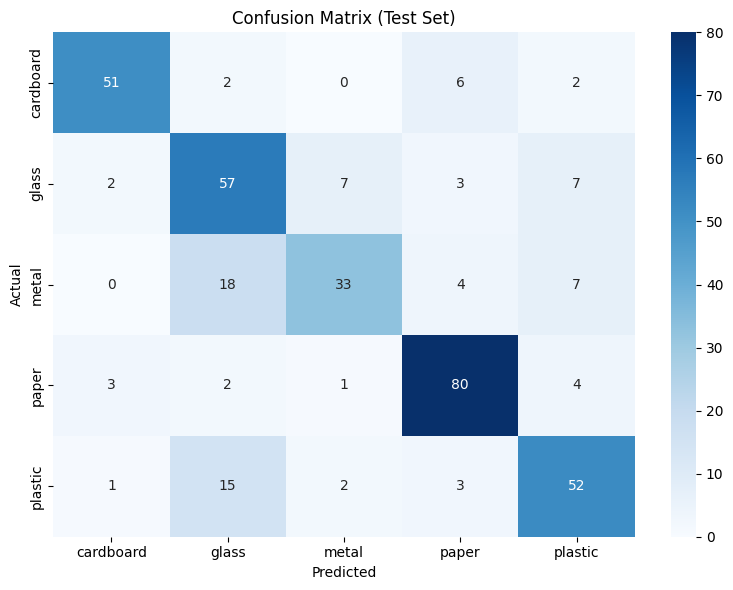

In [5]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
accuracy_score

# === Load data
X_train = np.load("D:/KULIAH/TELKOM_UNIVERSITY/SEMESTER_8/CITRA_DIGITAL/TUBES/KODE_Train/DATA_SPLIT_BARU/fitur_ekstraksi/X_train_aug.npy")
y_train = np.load("D:/KULIAH/TELKOM_UNIVERSITY/SEMESTER_8/CITRA_DIGITAL/TUBES/KODE_Train/DATA_SPLIT_BARU/fitur_ekstraksi/y_train_aug.npy")

X_valid = np.load("D:/KULIAH/TELKOM_UNIVERSITY/SEMESTER_8/CITRA_DIGITAL/TUBES/KODE_Train/DATA_SPLIT_BARU/fitur_ekstraksi/X_valid.npy")
y_valid = np.load("D:/KULIAH/TELKOM_UNIVERSITY/SEMESTER_8/CITRA_DIGITAL/TUBES/KODE_Train/DATA_SPLIT_BARU/fitur_ekstraksi/y_valid.npy")

X_test = np.load("D:/KULIAH/TELKOM_UNIVERSITY/SEMESTER_8/CITRA_DIGITAL/TUBES/KODE_Train/DATA_SPLIT_BARU/fitur_ekstraksi/X_test.npy")
y_test = np.load("D:/KULIAH/TELKOM_UNIVERSITY/SEMESTER_8/CITRA_DIGITAL/TUBES/KODE_Train/DATA_SPLIT_BARU/fitur_ekstraksi/y_test.npy")

# === Latih model KNN
knn = KNeighborsClassifier(n_neighbors=3)  # Bisa dicoba 3, 5, atau 7
knn.fit(X_train, y_train)

# === Validasi
print("=== Evaluasi di VALIDATION SET ===")
y_val_pred = knn.predict(X_valid)
print(classification_report(y_valid, y_val_pred))

# === Evaluasi Final di TEST SET
print("\n=== Evaluasi di TEST SET ===")
y_test_pred = knn.predict(X_test)
print(classification_report(y_test, y_test_pred))
print("Akurasi:", accuracy_score(y_test, y_test_pred))

# === Confusion Matrix
labels = sorted(np.unique(y_test))
cm = confusion_matrix(y_test, y_test_pred, labels=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap="Blues")
plt.title("Confusion Matrix (Test Set)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


=== Evaluasi Voting Classifier (KNN + SVM + RF) ===
              precision    recall  f1-score   support

   cardboard       0.87      0.85      0.86        61
       glass       0.80      0.87      0.84        76
       metal       0.79      0.77      0.78        62
       paper       0.87      0.96      0.91        90
     plastic       0.90      0.74      0.81        73

    accuracy                           0.85       362
   macro avg       0.85      0.84      0.84       362
weighted avg       0.85      0.85      0.84       362

Akurasi: 0.8453038674033149


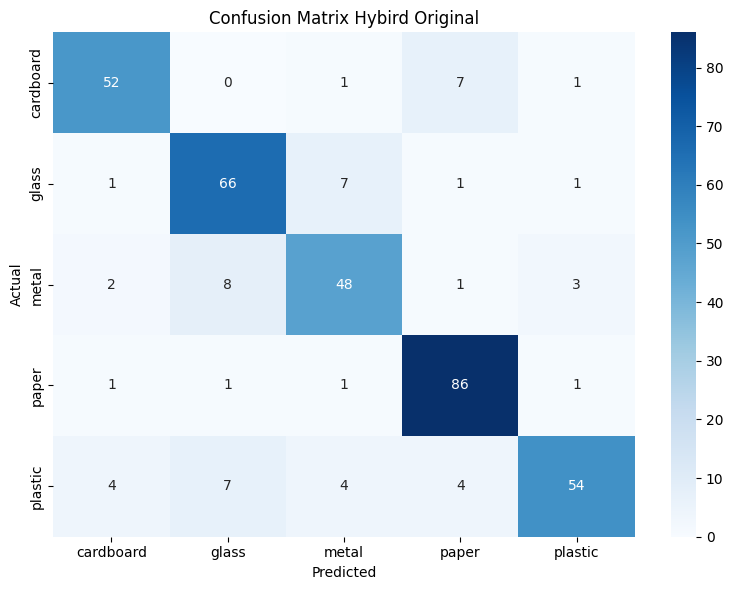

['D:\\KULIAH\\TELKOM_UNIVERSITY\\SEMESTER_8\\CITRA_DIGITAL\\TUBES\\KODE_Train\\model\\scaler_baru.pkl']

In [4]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
import warnings

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

warnings.filterwarnings("ignore")  # Supaya output bersih

# === Load fitur
X_train = np.load("D:/KULIAH/TELKOM_UNIVERSITY/SEMESTER_8/CITRA_DIGITAL/TUBES/KODE_Train/DATA_SPLIT_BARU/fitur_ekstraksi/X_train_aug.npy")
y_train = np.load("D:/KULIAH/TELKOM_UNIVERSITY/SEMESTER_8/CITRA_DIGITAL/TUBES/KODE_Train/DATA_SPLIT_BARU/fitur_ekstraksi/y_train_aug.npy")

X_test = np.load("D:/KULIAH/TELKOM_UNIVERSITY/SEMESTER_8/CITRA_DIGITAL/TUBES/KODE_Train/DATA_SPLIT_BARU/fitur_ekstraksi/X_test.npy")
y_test = np.load("D:/KULIAH/TELKOM_UNIVERSITY/SEMESTER_8/CITRA_DIGITAL/TUBES/KODE_Train/DATA_SPLIT_BARU/fitur_ekstraksi/y_test.npy")

# === Normalisasi fitur
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# === Definisi model-model dasar
knn = KNeighborsClassifier(n_neighbors=7)
svm = SVC(kernel='rbf', probability=True)
rf = RandomForestClassifier(n_estimators=200, random_state=42)

# === Voting Classifier dengan model-model yang lebih stabil
voting_model = VotingClassifier(estimators=[
    ('knn', knn),
    ('svm', svm),
    ('rf', rf)
], voting='soft')  # gunakan 'soft' untuk memanfaatkan probabilitas

# === Training dan prediksi
voting_model.fit(X_train, y_train)
y_pred = voting_model.predict(X_test)

# === Evaluasi
print("=== Evaluasi Voting Classifier (KNN + SVM + RF) ===")
print(classification_report(y_test, y_pred))
print("Akurasi:", accuracy_score(y_test, y_pred))

# === Label kelas (urutkan sesuai datasetmu)
class_labels = ['cardboard', 'glass', 'metal', 'paper', 'plastic']

# === Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=class_labels)

# === Visualisasi CM
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix Hybird Original')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

import joblib

joblib.dump(voting_model, 'D:/KULIAH/TELKOM_UNIVERSITY/SEMESTER_8/CITRA_DIGITAL/TUBES\KODE_Train/model/voting_model_baru.pkl')
joblib.dump(scaler, 'D:\KULIAH\TELKOM_UNIVERSITY\SEMESTER_8\CITRA_DIGITAL\TUBES\KODE_Train\model\scaler_baru.pkl')

